# The Device

In [6]:
import torch

# GPU
if torch.cuda.is_available():
    device = torch.device(f"cuda:{0}")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

We will use the GPU: Quadro RTX 8000


# utils

The code in this part come from https://github.com/hmohebbi/ValueZeroing.

In [7]:
import numpy as np

NUM_LABELS = {
    "ana": 2,
    "dna": 2,
    "dnaa": 2,
    "rpsv": 2,
    "darn": 2,
    "NA": 2,
}

blimp_to_label = {
    'singular': 0,
    'plural': 1,
}

MODEL_PATH = {
    'bert': 'bert-base-uncased',
    'roberta': 'roberta-base',
    'electra': 'google/electra-base-generator',
    'deberta': 'microsoft/deberta-v3-base'
}

BLIMP_TASKS = [
    "ana",
    'dna',
    "dnaa",
    "rpsv",
    "darn",
    "NA",
]

def blimp_to_features(data, tokenizer, max_length, input_masking, mlm):
    all_features = []
    for example in data:
        text = example['sentence_good']
        tokens = []
        cue_indices = []
        # token to id
        for w_ind, word in enumerate(text):
            ids = tokenizer.encode(word, add_special_tokens=False)
            if w_ind in example['cue_indices']:
                cue_indices.append(len(tokens))
            if w_ind == example['target_index']:
                target_index = len(tokens)
            tokens.extend(ids)
        
        tokens = [tokenizer.cls_token_id] + tokens + [tokenizer.sep_token_id]
        cue_indices = [x+1 for x in cue_indices] # 'cause of adding cls
        target_index += 1 # 'cause of adding cls
        if input_masking:
            tokens[target_index] = tokenizer.mask_token_id

        # padding
        length = len(tokens)
        inputs = {}
        inputs['input_ids'] = tokens if max_length is None else tokens + [tokenizer.pad_token_id]*(max_length - length)
        inputs['attention_mask'] = [1]*length if max_length is None else [1]*length + [0]*(max_length - length)
        inputs['token_type_ids'] = [0]*length if max_length is None else [0]*max_length
        inputs['target_index'] = target_index
        inputs['labels'] = tokenizer.convert_tokens_to_ids(example['good_word']) if mlm else blimp_to_label[example['labels']]
        inputs['good_token_id'] = tokenizer.convert_tokens_to_ids(example['good_word'])
        inputs['bad_token_id'] = tokenizer.convert_tokens_to_ids(example['bad_word'])

        # As a 2d tensor, we need all rows to have the same length. So, we add -1 to the end of each list.
        inputs['cue_indices'] = cue_indices + (10 - len(cue_indices)) * [-1]

        all_features.append(inputs)
    return all_features[0] if len(all_features) == 1 else all_features

PREPROCESS_FUNC = {
    'ana': blimp_to_features,
    'dna': blimp_to_features,
    'dnaa': blimp_to_features,
    'rpsv': blimp_to_features,
    'darn': blimp_to_features,
    'NA': blimp_to_features,
}

In [ ]:
SELECTED_GPU = 0
MODEL_NAME = 'roberta'
FIXED = False
TASK = "NA"
MAX_LENGTH = 32
NUM_TRAIN_EPOCHS = 1
PER_DEVICE_BATCH_SIZE = 64

INPUT_MASKING = True
MLM = True
LEARNING_RATE = 3e-5
LR_SCHEDULER_TYPE = "linear" 
WARMUP_RATIO = 0.1
SEED = 42

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss

from datasets import (
    load_dataset,
    load_from_disk,
    load_metric,
)

from transformers import BertForMaskedLM
# from customized_modeling_bert import BertForMaskedLM
from modeling.customized_modeling_roberta import RobertaForMaskedLM
# from modeling.customized_modeling_electra import ElectraForMaskedLM
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AdamW,
    get_scheduler,
    default_data_collator,
    set_seed,
)
set_seed(SEED)

# Load Dataset
if TASK in BLIMP_TASKS:
    data_path = f"./BLIMP Dataset/{MODEL_NAME}/"
    data = load_from_disk(data_path)
    train_data = data['train']
    eval_data = data['test']
else:
    print("Not implemented yet!")
    exit()
train_data = train_data.shuffle(SEED)
num_labels = NUM_LABELS[TASK]

# Download Tokenizer & Model
config = AutoConfig.from_pretrained(MODEL_PATH[MODEL_NAME], num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH[MODEL_NAME])  

if MODEL_NAME == "bert":
    model = BertForMaskedLM.from_pretrained(MODEL_PATH[MODEL_NAME], config=config)
elif MODEL_NAME == "roberta":
    model = RobertaForMaskedLM.from_pretrained(MODEL_PATH[MODEL_NAME], config=config)
# elif MODEL_NAME == "electra":
#     model = ElectraForMaskedLM.from_pretrained(MODEL_PATH[MODEL_NAME], config=config)
else:
    print("model doesn't exist")

model.to(device)

# Preprocessing
train_dataset = PREPROCESS_FUNC[TASK](train_data, tokenizer, MAX_LENGTH, input_masking=INPUT_MASKING, mlm=MLM)
eval_dataset = PREPROCESS_FUNC[TASK](eval_data, tokenizer, MAX_LENGTH, input_masking=INPUT_MASKING, mlm=MLM)

train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn= default_data_collator, batch_size=PER_DEVICE_BATCH_SIZE)
eval_dataloader = DataLoader(eval_dataset, collate_fn= default_data_collator, batch_size=PER_DEVICE_BATCH_SIZE)

num_update_steps_per_epoch = len(train_dataloader)
max_train_steps = NUM_TRAIN_EPOCHS * num_update_steps_per_epoch 

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
        name=LR_SCHEDULER_TYPE,
        optimizer=optimizer,
        num_warmup_steps=WARMUP_RATIO * max_train_steps,
        num_training_steps=max_train_steps,
    )

# metric & Loss
metric = load_metric("accuracy")
loss_fct = CrossEntropyLoss()

tag = "forseqclassification_"
tag += "pretrained" if FIXED else "finetuned" 
if MLM:
    tag += "_MLM"

# Evaluation

The code in this part come from https://github.com/hmohebbi/ValueZeroing.

In [4]:
model.load_state_dict(torch.load(f'{MODEL_NAME}_full_{tag}_epoch{NUM_TRAIN_EPOCHS}.pt'))

<All keys matched successfully>

In [9]:
model.eval()
for batch in eval_dataloader:
    if MLM:
        good_token_id = batch.pop('good_token_id').to(device)
        bad_token_id = batch.pop('bad_token_id').to(device)
    target_index = batch.pop('target_index').to(device) # size: [64]
    batch.pop('labels').to(device)
    batch.pop('cue_indices').to(device)
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits[torch.arange(outputs.logits.size(0)), target_index] # size: [64, 30522]

    if MLM:
        good_logits = logits[torch.arange(logits.size(0)), good_token_id]
        bad_logits = logits[torch.arange(logits.size(0)), bad_token_id]
        logits_of_interest = torch.stack([good_logits, bad_logits], dim=1)
        labels = torch.zeros(logits_of_interest.shape[0], dtype=torch.int64, device=device)
        predictions = torch.argmax(logits_of_interest, dim=-1)
        metric.add_batch(predictions=predictions, references=labels)
    else:
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch['labels'])

eval_metric = metric.compute()
print(f"epoch: {eval_metric}")  


epoch: {'accuracy': 0.8568840579710145}


## Average Precision

Defining the method for calculating Average Precision.

In [10]:
# Cleaning the tensors from -1 padding
def CI_cleaner(CI):
    first_pad_index = torch.where(CI == -1)[0][0].item() # We have used -1 as paddings of CIs
    return CI[:first_pad_index]

# Calculating Precision
def precision(TP, FP):
    return TP / (TP + FP)

# Calculating Recall
def recall(TP, FN):
    return TP / (TP + FN)

# Calculating Average Precision
def avg_precision(topk, CI):
    R_base = 0 # The starting recall before the first round
    AP, TP, FP, FN = 0, 0, 0, len(CI)
    previous_recall = R_base
    for i in range(len(topk)):
        if topk[i] in CI:
            TP += 1
            FN -= 1
        else:
            FP += 1

        AP += (recall(TP, FN) -  previous_recall) * precision(TP, FP)
        previous_recall = recall(TP, FN)

    return AP

topk = torch.tensor([1, 0, 3, 4, 2])
CI = torch.tensor([3, -1, -1, -1])
# CI = CI_cleaner(CI)
# print(avg_precision(topk, CI))

# Merging Two Ranking

A simple method to rank any two given rankings.

In [11]:
def merge_two_ranks(rank1, rank2):

    merged_importance = list()
    for value in range(len(rank1)):
        temp_sum = 0
        temp_sum += torch.where(rank1 == value)[0][0].item()
        temp_sum += torch.where(rank2 == value)[0][0].item()
        merged_importance.append(temp_sum)
    
    merged_importance_topk = torch.topk(torch.tensor(merged_importance), k=len(rank1), largest=False, dim=0).indices    

    return merged_importance_topk
    
# rank1 = torch.tensor([4, 1, 2, 0, 3])
# rank2 = torch.tensor([2, 3, 0, 1, 4])

# merge_two_ranks(rank1, rank2)

# NormXLogit, LogAt, and more ...

In [15]:
# We need the head seperat
if MODEL_NAME == 'bert':
    base = model.bert
    head = model.cls
elif MODEL_NAME == 'roberta':
    base = model.roberta
    head = model.lm_head


In [16]:
importance_methods = [
    'Random Baseline',
    'LogAt(Target)',
    'LogAt(Foil)',
    'LogAt(Target) + LogAt(Foil)',
    'Merged Ranks(LogAt(Target), LogAt(Foil))',
    'L2 norm',
    'NormXLogit',
    'EachLayerNormXLogit',
    'OP', # Original Prediction
    'OP_NXL',
    'word "numbers"',
    'word "singular"',
    'word "plural"',
    'word "noun"',
    'word "apple"',
]

excluded_importance_methods = [
    'GlobEnc¬',
    'ALTI¬',
    'Value Zeroing',
]

To check for layer 0, set `for layer in diagram_layers:`, comment the `if layer != 0` conditions.

In [18]:
import random
from torch import linalg as LA
import torch
import torch.nn.functional as F
random.seed(42)

# To check for methods 
diagram_layers = range(13)

APs = dict()
for layer in range(1, 13): # 'in diagram_layers' for layer 0 
    for importance_method in importance_methods:
        APs[f'{importance_method}_layer{layer}'] = list()
        
DPs = dict()
for layer in range(1, 13): # 'in diagram_layers' for layer 0
    for importance_method in importance_methods:
        DPs[f'{importance_method}_layer{layer}'] = list()

model.eval()
for batch in tqdm(eval_dataloader):
    if MLM:
        good_token_id = batch.pop('good_token_id').to(device)
        bad_token_id = batch.pop('bad_token_id').to(device)
    target_indices = batch.pop('target_index').to(device) # size: [64]
    cue_indices = batch.pop('cue_indices').to(device) # size: [64, 10]
    batch.pop('labels').to(device)
    batch = {k: v.to(device) for k, v in batch.items()}
    batch_lengths = batch['attention_mask'].sum(dim=-1)  # a tensor containing the length of each sentence in the batch

    with torch.no_grad():
        outputs = model(**batch) # outputs.logits.size(): [64, 32, 30522]
        
    logits = outputs.logits[torch.arange(outputs.logits.size(0)), target_indices] # size: [64, 30522]
    predicted_token_ids = torch.max(logits, dim=1).indices
    
    for layer in diagram_layers:
        with torch.no_grad():
            # For layer=12 -> layerwise_outputs = outputs.logits
            hidden_states = base(**batch, output_hidden_states=True).hidden_states[layer]
            layerwise_outputs = head(hidden_states)
            if layer == 0:
                hidden_states0 = hidden_states
                layerwise_outputs0 = layerwise_outputs
        if MLM:
            if layer == 0:
                good_logits = logits[torch.arange(logits.size(0)), good_token_id]
                bad_logits = logits[torch.arange(logits.size(0)), bad_token_id]
                logits_of_interest = torch.stack([good_logits, bad_logits], dim=1)
                labels = torch.zeros(logits_of_interest.shape[0], dtype=torch.int64, device=device)
                predictions = torch.argmax(logits_of_interest, dim=-1) # Prediction from good and bad logits
                true_pred = torch.argmax(logits, dim=-1) # Prediction from all 30522 tokens
                metric.add_batch(predictions=predictions, references=labels)
            
            for batch_sample in range(logits.size(0)):
                
                CI = CI_cleaner(cue_indices[batch_sample])

                # Here we look at the logits for the good_token_id as it may not the most probable token in some sentences
                for importance_method in importance_methods:
                    
                    if importance_method in ['LogAt(Target)', 'LogAt(Foil)', 'LogAt(Target) + LogAt(Foil)', 'Merged Ranks(LogAt(Target), LogAt(Foil))']:
                        importance_good = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], good_token_id[batch_sample]]
                        importance_bad = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], bad_token_id[batch_sample]]
                        importance_good_topk = torch.topk(importance_good, k=batch_lengths[batch_sample], largest=True, dim=0).indices
                        importance_bad_topk = torch.topk(importance_bad, k=batch_lengths[batch_sample], largest=True, dim=0).indices
                    elif importance_method == 'word "numbers"':
                        target_token_id = tokenizer.encode("numbers", add_special_tokens=False)[0]
                        importance = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], target_token_id]
                    elif importance_method == 'word "singular"':
                        target_token_id = tokenizer.encode("singular", add_special_tokens=False)[0]
                        importance = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], target_token_id]
                    elif importance_method == 'word "plural"':
                        target_token_id = tokenizer.encode("plural", add_special_tokens=False)[0]
                        importance = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], target_token_id]
                    elif importance_method == 'word "noun"':
                        target_token_id = tokenizer.encode("noun", add_special_tokens=False)[0]
                        importance = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], target_token_id]
                    elif importance_method == 'word "apple"':
                        target_token_id = tokenizer.encode("apple", add_special_tokens=False)[0]
                        importance = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], target_token_id]
                    elif importance_method == 'L2 norm':
                        importance = LA.vector_norm(hidden_states[batch_sample][:batch_lengths[batch_sample]], ord=2, dim=1)
                    elif importance_method == 'NormXLogit':
                        importance = LA.vector_norm(hidden_states0[batch_sample][:batch_lengths[batch_sample]], ord=2, dim=1)
                        importance = importance * importance_good
                    elif importance_method == 'EachLayerNormXLogit':
                        importance = LA.vector_norm(hidden_states[batch_sample][:batch_lengths[batch_sample]], ord=2, dim=1)
                        importance = importance * importance_good
                    elif importance_method == 'OP':
                        importance_OP = layerwise_outputs[batch_sample][:batch_lengths[batch_sample], predicted_token_ids[batch_sample]]
                        importance = importance_OP
                    elif importance_method == 'OP_NXL':
                        importance = LA.vector_norm(hidden_states0[batch_sample][:batch_lengths[batch_sample]], ord=2, dim=1)    
                        importance = importance * importance_OP
                    elif importance_method == 'Random Baseline':
                        importance = torch.tensor(([1] * batch_lengths[batch_sample]), dtype=torch.float).to(device)
                        importance = F.softmax(importance, dim=0)
                        
                    if importance_method == 'LogAt(Target)':
                        importance_topk = importance_good_topk
                        importance = importance_good # For Dot Product
                    elif importance_method == 'LogAt(Foil)':
                        importance_topk = importance_bad_topk
                        importance = importance_bad # For Dot Product
                    elif importance_method == 'LogAt(Target) + LogAt(Foil)':
                        importance = importance_good + importance_bad
                        importance_topk = torch.topk(importance, k=batch_lengths[batch_sample], largest=True, dim=0).indices
                    elif importance_method == 'Merged Ranks(LogAt(Target), LogAt(Foil))':
                        importance_topk = merge_two_ranks(importance_good_topk, importance_bad_topk).to(device)
                    elif importance_method == 'Random Baseline':
                        importance_topk = list(range(batch_lengths[batch_sample]))
                        random.shuffle(importance_topk)
                        importance_topk = torch.tensor(importance_topk).to(device)
                    elif importance_method not in excluded_importance_methods:
                        importance_topk = torch.topk(importance, k=batch_lengths[batch_sample], largest=True, dim=0).indices
                        
                    mask_index = target_indices[batch_sample]
                    mask_index = torch.reshape(mask_index, (1,)) # convert from tensor(k) to tensor([k])
#                     special_tokens_indices = torch.tensor([0, batch_lengths[batch_sample] - 1]).to(device) # Index of [CLS] and [SEP]
#                     values_to_remove = torch.concat((mask_index, special_tokens_indices)) # These are indices corresponding to [CLS], [SEP], and target token
                    
                    # Average Precision
                    importance_topk = importance_topk[~torch.isin(importance_topk, mask_index)]
                    if layer != 0: # For layer 0, comment this line and unindent the line after it
                        APs[f'{importance_method}_layer{layer}'].append(avg_precision(importance_topk, CI))

                    # Dot Product
                    importance = torch.concat((importance[:mask_index.item()], importance[mask_index.item() + 1:]))
                    importance_softmax = F.softmax(importance, dim=0)
#                     importance_softmax = torch.abs(importance) / torch.abs(importance).sum()

                    if CI[-1].item() > mask_index.item():
                        CI_scores = importance_softmax[CI - 1] # Because of the removed mask_index
                    else:
                        CI_scores = importance_softmax[CI]
                        
                    if CI.shape[0] > 1:
                        CI_scores = CI_scores.sum(axis=0)
                        
                    if layer != 0: # For layer 0, comment this line and unindent the line after it
                        DPs[f'{importance_method}_layer{layer}'].append(CI_scores.item())
                    
        else:
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch['labels'])

eval_metric = metric.compute()
print(f"epoch: {eval_metric}")


  0%|          | 0/35 [00:00<?, ?it/s]

epoch: {'accuracy': 0.8556338028169014}


## mean Dot Product (Pre-trained)

In [22]:
# Averaging across all samples
mDP = dict()
for layer in range(1, 13):
    for importance_method in importance_methods:
        mDP[f'{importance_method}_layer{layer}'] = sum(DPs[f'{importance_method}_layer{layer}']) / len(DPs[f'{importance_method}_layer{layer}'])

In [23]:
# Make a list for each method
mDP_visualize = {}

for importance_method in importance_methods:
    layer_values = []
    for i in range(1, 13):
        layer_values.append(mDP[f'{importance_method}_layer{i}'])
    mDP_visualize[importance_method] = layer_values


In [146]:
# The results from GlobEnc, ALTI, and Value Zeroing have come from corresponding provided notebooks
new_mDP_visualize = dict()

new_mDP_visualize['Random Baseline'] = mDP_visualize['Random Baseline']
new_mDP_visualize['GlobEnc¬'] = [0.1049, 0.1069, 0.1134, 0.1020, 0.1128, 0.1199, 0.1050, 0.1192, 0.1213, 0.1047, 0.1144, 0.1303]
new_mDP_visualize['ALTI¬'] = [0.1000, 0.1535, 0.1346, 0.1101, 0.1351, 0.1429, 0.1394, 0.1363, 0.1353, 0.1239, 0.1443, 0.1748]
new_mDP_visualize['Value Zeroing'] = [0.1210, 0.1553, 0.1273, 0.0903, 0.1152, 0.1271, 0.1091, 0.1366, 0.1186, 0.1195, 0.1318, 0.1573]
new_mDP_visualize['ℓ2 norm'] = mDP_visualize['L2 norm']
new_mDP_visualize['LogAt(Foil)'] = mDP_visualize['LogAt(Foil)']
new_mDP_visualize['LogAt(Target)'] = mDP_visualize['LogAt(Target)']
new_mDP_visualize['NormXLogit'] = mDP_visualize['NormXLogit']
new_mDP_visualize['LogAt("noun")'] = mDP_visualize['word "noun"']
new_mDP_visualize['LogAt("apple")'] = mDP_visualize['word "apple"']
new_mDP_visualize['LogAt("plural")'] = mDP_visualize['word "plural"']

## mean Average Precision (Pre-trained)

In [25]:
# Averaging across all samples
mAP = dict()
for layer in range(1, 13):
    for importance_method in importance_methods:
        mAP[f'{importance_method}_layer{layer}'] = sum(APs[f'{importance_method}_layer{layer}']) / len(APs[f'{importance_method}_layer{layer}'])

In [26]:
# Make a list for each method
mAP_visualize = {}

for importance_method in importance_methods:
    layer_values = []
    for i in range(1, 13):
        layer_values.append(mAP[f'{importance_method}_layer{i}'])
    mAP_visualize[importance_method] = layer_values


In [152]:
# The results from GlobEnc, ALTI, and Value Zeroing have come from corresponding provided notebooks
new_mAP_visualize = dict()

new_mAP_visualize['Random Baseline'] = mAP_visualize['Random Baseline']
new_mAP_visualize['GlobEnc¬'] = [0.29353671136159953, 0.3428355231122479, 0.3661429698928716, 0.2674434673360707, 0.31858515302635293, 0.34495581585853935, 0.2842268998074423, 0.34539070185299914, 0.3265184481704264, 0.2922642782829635, 0.3191821681466628, 0.352063390024211]
new_mAP_visualize['ALTI¬'] = [0.24847647621734462, 0.3781740227312561, 0.38813648741068457, 0.30460218191646077, 0.37426771660807046, 0.374563165041807, 0.3504273337748207, 0.3617342698439846, 0.3520740295961088, 0.32868386991179194, 0.37172958476457274, 0.39374281351833057]
new_mAP_visualize['Value Zeroing'] = [0.33297120160731064, 0.35506991249036896, 0.3675264035153822, 0.2629552616098428, 0.31504201560673706, 0.35902219496619014, 0.3075139568833522, 0.3653852097191506, 0.3403612887286204, 0.307320248072889, 0.33685834170319817, 0.3594334375077499]
new_mAP_visualize['ℓ2 norm'] = mAP_visualize['L2 norm']
new_mAP_visualize['LogAt(Foil)'] = mAP_visualize['LogAt(Foil)']
new_mAP_visualize['LogAt(Target)'] = mAP_visualize['LogAt(Target)']
new_mAP_visualize['NormXLogit'] = mAP_visualize['NormXLogit']
# new_mAP_visualize['LogAt("noun")'] = mAP_visualize['word "noun"']
# new_mAP_visualize['LogAt("apple")'] = mAP_visualize['word "apple"']
# new_mAP_visualize['LogAt("plural")'] = mAP_visualize['word "plural"']

## mean Dot Product (Fine-tuned)

In [166]:
# Averaging across all samples
mDP = dict()
for layer in range(1, 13):
    for importance_method in importance_methods:
        mDP[f'{importance_method}_layer{layer}'] = sum(DPs[f'{importance_method}_layer{layer}']) / len(DPs[f'{importance_method}_layer{layer}'])

In [167]:
# Make a list for each method
mDP_visualize = {}

for importance_method in importance_methods:
    layer_values = []
    for i in range(1, 13):
        layer_values.append(mDP[f'{importance_method}_layer{i}'])
    mDP_visualize[importance_method] = layer_values


In [170]:
# The results from GlobEnc, ALTI, and Value Zeroing have come from corresponding provided notebooks
new_mDP_visualize = dict()

new_mDP_visualize['Random Baseline'] = mDP_visualize['Random Baseline']
new_mDP_visualize['GlobEnc¬'] = [0.1055, 0.1067, 0.1150, 0.1006, 0.1124, 0.1160, 0.1051, 0.1037, 0.1312, 0.0940, 0.1273, 0.0919]
new_mDP_visualize['ALTI¬'] = [0.1008, 0.1513, 0.1387, 0.1094, 0.1243, 0.1329, 0.1418, 0.1130, 0.1555, 0.1157, 0.1642, 0.1291]
new_mDP_visualize['Value Zeroing'] = [0.1219, 0.1540, 0.1340, 0.0897, 0.1179, 0.1265, 0.1097, 0.1106, 0.1452, 0.0930, 0.1408, 0.0769]
new_mDP_visualize['ℓ2 norm'] = mDP_visualize['L2 norm']
new_mDP_visualize['LogAt(Foil)'] = mDP_visualize['LogAt(Foil)']
new_mDP_visualize['LogAt(Target)'] = mDP_visualize['LogAt(Target)']
new_mDP_visualize['NormXLogit'] = mDP_visualize['NormXLogit']
# new_mDP_visualize['LogAt("noun")'] = mDP_visualize['word "noun"']
# new_mDP_visualize['LogAt("apple")'] = mDP_visualize['word "apple"']
# new_mDP_visualize['LogAt("plural")'] = mDP_visualize['word "plural"']

## mean Average Precision (Fine-tuned)

In [172]:
# Averaging across all samples
mAP = dict()
for layer in range(1, 13):
    for importance_method in importance_methods:
        mAP[f'{importance_method}_layer{layer}'] = sum(APs[f'{importance_method}_layer{layer}']) / len(APs[f'{importance_method}_layer{layer}'])

In [ ]:
# Make a list for each method
mAP_visualize = {}

for importance_method in importance_methods:
    layer_values = []
    for i in range(1, 13):
        layer_values.append(mAP[f'{importance_method}_layer{i}'])
    mAP_visualize[importance_method] = layer_values


In [179]:
# The results from GlobEnc, ALTI, and Value Zeroing have come from corresponding provided notebooks
new_mAP_visualize = dict()

new_mAP_visualize['Random Baseline'] = mAP_visualize['Random Baseline']
new_mAP_visualize['GlobEnc¬'] = [0.29497986424836653, 0.34115687026569663, 0.3699041272101137, 0.2659901258731381, 0.30648929408720155, 0.32037714502900505, 0.28131746623844195, 0.28891366741031027, 0.36654652620175787, 0.2702167037045549, 0.3625181160677095, 0.23063080852453038]
new_mAP_visualize['ALTI¬'] = [0.25378783982724146, 0.37580808697834556, 0.384735210937058, 0.3131100441352606, 0.32833106186536964, 0.3317546323066029, 0.35110838518617177, 0.30322958040349385, 0.4014851593655965, 0.3255487871466542, 0.4042661331723848, 0.3256675418105456]
new_mAP_visualize['Value Zeroing'] = [0.3335212661009892, 0.3548119735779855, 0.36945236711989654, 0.2608768614740516, 0.3097970504860164, 0.33552783147322407, 0.3023322261796221, 0.3060584584746651, 0.3790604487316177, 0.28582837660649224, 0.3609275089169735, 0.22463820826419037]
new_mAP_visualize['ℓ2 norm'] = mAP_visualize['L2 norm']
new_mAP_visualize['LogAt(Foil)'] = mAP_visualize['LogAt(Foil)']
new_mAP_visualize['LogAt(Target)'] = mAP_visualize['LogAt(Target)']
new_mAP_visualize['NormXLogit'] = mAP_visualize['NormXLogit']
# new_mAP_visualize['LogAt("noun")'] = mAP_visualize['word "noun"']
# new_mAP_visualize['LogAt("apple")'] = mAP_visualize['word "apple"']
# new_mAP_visualize['LogAt("plural")'] = mAP_visualize['word "plural"']

# Visualization

The plots do not consider the layer 0 (the importances based on word embeddings), as GlobEnc, ALTI, and Value Zeroing takes no account of this layer.

In [ ]:
plot_mAX = new_mAP_visualize # new_mDP_visualize

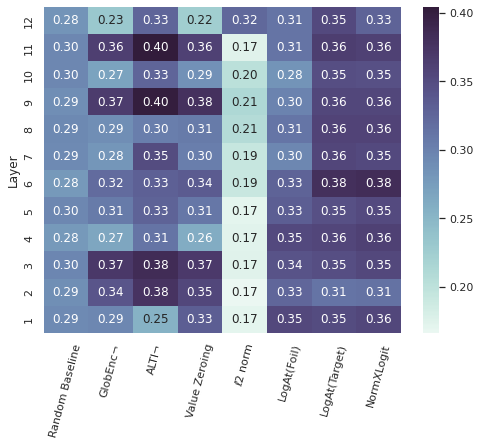

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

combined_data = list(plot_mAX.values())
plt.figure(figsize=(len(combined_data), 6))

# Combine data into a single matrix
combined_data = np.array(combined_data).T

combined_data = np.flipud(combined_data)

# Create a heatmap using Seaborn
sns.set()
ax = sns.heatmap(combined_data, annot=True, fmt=".2f", cmap=sns.cubehelix_palette(start=0.5, rot=-0.46, light=.95, as_cmap=True), cbar=True)

# Draw a vertical line after the 8th column
# ax.axvline(x=8, color='black', linestyle='-', linewidth=2)  # x=8 because it counts from 0

# Set axis labels
# ax.set_xlabel("X-axis")
ax.set_ylabel("Layer")

# Set title
ax.set_title(f'')

new_x_labels = list(plot_mAX.keys())
ax.set_xticklabels(new_x_labels, rotation=75)
# ax.xticks(rotation=90)

new_y_labels = list(reversed(range(1, 13)))
ax.set_yticklabels(new_y_labels)

# Show the plot
plt.show()